# Computer Vision

This is a fairly complex topic so I'd write more decleratively with lesser background notes, although I might link resources here and there as required.

We'll start small and scale up. Be sure to use GPU for this project otherwise it will be very slow.

In [1]:
# define imports
import json 

import matplotlib.pyplot as plt
import tensorflow as tf

2023-09-24 14:51:03.462366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check GPU 

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
gpus

if gpus:
    tf.device(gpus[0])

Num GPUs Available:  1


2023-09-24 14:51:43.473824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 14:51:43.474870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 14:51:43.475912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 14:51:49.194602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 14:51:49.195274: I tensorflow/compile

In [7]:
data_dir = "./food-101/images/"
data_temp_dir = "./food-101/images-temp/"
conf_dir = "./food-101/meta/"

class_names = ["pizza", "steak"]

data_sets = {}
data_sets_with_paths = {}

with open(f"{conf_dir}/test.json", "r") as file:
    stuff = file.read()
    test_data_set = json.loads(stuff)
    file.close()

with open(f"{conf_dir}/train.json", "r") as file:
    stuff = file.read()
    train_data_set = json.loads(stuff)
    file.close()

for classes in class_names:

    data_sets[classes] = {}
    data_sets_with_paths[classes] = {}

    image_paths = []
    for image in test_data_set[classes]:
        image_paths.append(data_dir + image)
    data_sets_with_paths[classes]['test_set'] = image_paths

    image_paths = []
    for image in train_data_set[classes]:
        image_paths.append(data_dir + image)
    data_sets_with_paths[classes]['train_set'] = image_paths
    
    data_sets[classes]['test_set'] = test_data_set[classes]
    data_sets[classes]['train_set'] = train_data_set[classes]

## Input the data

In [8]:
with tf.device('/GPU:0'):
  print("using", gpus[0])
  tf.random.set_seed(42)

  batch_size = 32
  img_height = 180
  img_width = 180

  print("starting")
  train_ds = tf.keras.utils.image_dataset_from_directory(
      data_temp_dir, 
      validation_split=0.2, 
      subset="training", 
      seed=42, 
      image_size=(img_height, img_width), 
      batch_size=batch_size
      )
  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_temp_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

class_names = train_ds.class_names

using PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
starting
Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


## Visualize the data

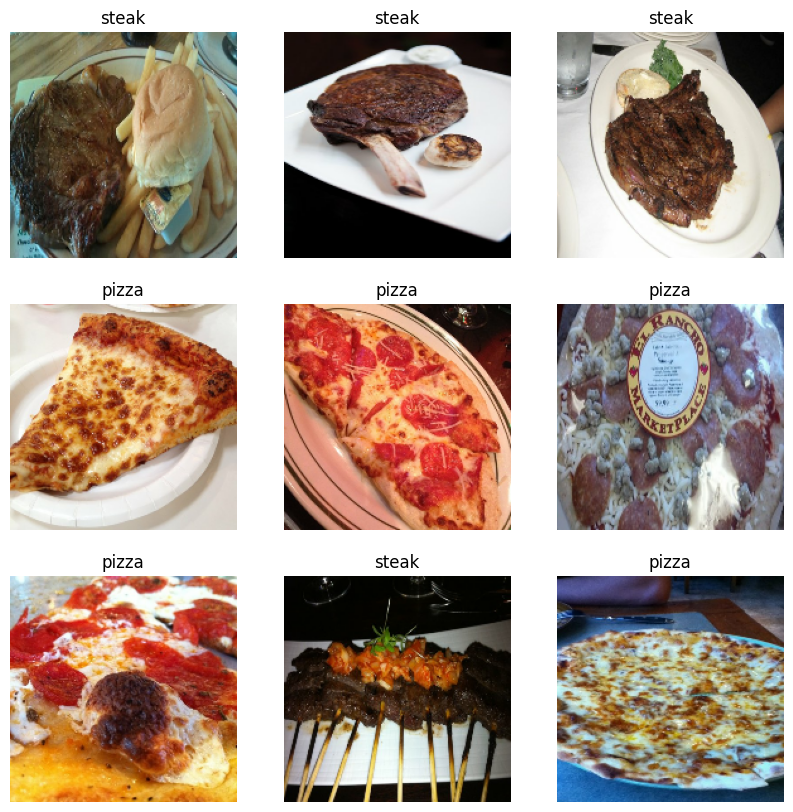

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [10]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip(
        "horizontal",
        input_shape=(
            img_height,
            img_width,
            3
          )),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# Build the model
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [11]:
# Fit the model
epochs=10
with tf.device('/GPU:0'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Epoch 1/10


2023-09-24 15:03:03.454684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-24 15:03:17.979313: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb654009810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-24 15:03:17.980854: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-09-24 15:03:19.861870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-24 15:03:22.982700: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 79s 888ms/step - loss: 0.6159 - accuracy: 0.6869 - val_loss: 0.3791 - val_accuracy: 0.8375
Epoch 2/10
50/50 [==============================] - 34s 568ms/step - loss: 0.3877 - accuracy: 0.8319 - val_loss: 0.3160 - val_accuracy: 0.8725
Epoch 3/10
50/50 [==============================] - 37s 664ms/step - loss: 0.3191 - accuracy: 0.8712 - val_loss: 0.3069 - val_accuracy: 0.8750
Epoch 4/10
50/50 [==============================] - 27s 473ms/step - loss: 0.2917 - accuracy: 0.8750 - val_loss: 0.3223 - val_accuracy: 0.8700
Epoch 5/10
50/50 [==============================] - 31s 555ms/step - loss: 0.2344 - accuracy: 0.9013 - val_loss: 0.4241 - val_accuracy: 0.8300
Epoch 6/10
50/50 [==============================] - 14s 203ms/step - loss: 0.1814 - accuracy: 0.9281 - val_loss: 0.3383 - val_accuracy: 0.8700
Epoch 7/10
50/50 [==============================] - 10s 180ms/step - loss: 0.1167 - accuracy: 0.9656 - val_loss: 0.3801 - val_accuracy: 0.8550
Epoch 8/10